# Struttura dei test

Per la fase di test sono stati generati dei dataset tramite la funzione
`make_classification` del modulo `scikit-learn`. Ogni dataset ha un totale di
100 punti, 90 dei quali sono stati utilizzati per il training dei modelli. Ne
segue che l'algoritmo genetico è stato eseguito su un totale di 10 punti per
dataset. I parametri che variano da un dataset all'altro sono:

- **Numero di feature di ogni punto**: 2, 4, 8, 16, 32.
- **Numero di classi possibili per ogni punto**: 2.
- **Numero di cluster per ogni classe**: 1, 2.
- **Seme di casualità per il generatore**: 0, 1, 2, 3, 4.

Per i test effettuati sono stati presi in considerazione tre modelli differenti
del modulo `scikit-learn`: `RandomForestClassifier`, `SVC` e `MLPClassifier`.
Su ognuno dei dataset è stato eseguito l'algoritmo genetico usando tutti e tre
i modelli e, per ognuno di essi, popolazioni sintetiche da 1000, 2000 e 4000
individui.

## Dataset dei risultati

Ogni riga del dataset contiene:

- **Informazioni sul dataset**:
  - **samples**: numero di punti, per ciascun dataset, su cui è stato eseguito
    l'algoritmo genetico.
  - **features**: numero di feature dei punti nel dataset.
  - **classes**: numero di classi possibili per un determinato dataset.
  - **clusters**: numero di cluster per classe.
  - **seed**: seme di casualità con cui è stato generato il dataset.
- **Parametri algoritmo genetico**:
  - **population_size**: numero di individui sintetici.
  - **point**: punto del dataset da cui vengono generati gli altri punti.
  - **class**: classe del punto.
  - **target**: classe target dell'algoritmo genetico.
  - **model**: il modello utilizzato per la classificazione.
- **Risultati**:
  - **min/mean/max_fitness**: valori minimo, medio e massimo di fitness, della
    popolazione generata dall'algoritmo genetico.
  - **fitness_std**: deviazione standard dei valori di fitness della popolazione
    sintetica finale.
  - **accuracy**: valore di _precisione_ dell'algoritmo genetico. Si tratta
    della percentuale di individui sintetici classificati nella classe target.

Possiamo quindi vedere ogni riga come una singola esecuzione dell'algoritmo
genetico su uno specifico punto, di uno specifico dataset e con una specifica
classe target.


In [1]:
import pandas as pd

rf = pd.read_csv("../results/neighborhood_RandomForestClassifier.csv")
svm = pd.read_csv("../results/neighborhood_SVC.csv")
mlp = pd.read_csv("../results/neighborhood_MLPClassifier.csv")
df = pd.concat([rf, svm[svm["clusters"] == 1], mlp[mlp["clusters"] == 1]], axis=0)

### Conversione fitness-distanza

Dato che i valori di fitness non sono altro che la distanza di ogni punto
sintetico dal punto preso in esame, moltiplicata per un peso di $-1$, possiamo
convertire le tre colonne di fitness in valori di distanza rimoltiplicandole
per $-1$ di modo da avere valori meglio interpretabili.

Ovviamente ciò che era considerato un valori di fitness minimo, diventerà
un valore di distanza massimo (stesso discorso per i valori di fitness massimi).


In [2]:
df[["min_fitness", "mean_fitness", "max_fitness"]] *= -1.0
df = df.rename(
    columns={
        "min_fitness": "max_distance",
        "mean_fitness": "mean_distance",
        "fitness_std": "distance_std",
        "max_fitness": "min_distance",
    }
)

df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,4,2,1,0,1000,0,1,0,RandomForestClassifier,2.435582,1.661742,0.729705,0.325748,1.0
1,10,4,2,1,0,1000,0,1,1,RandomForestClassifier,0.529250,0.298525,0.143279,0.000396,1.0
2,10,4,2,1,0,1000,1,1,0,RandomForestClassifier,1.755410,1.592907,0.095327,1.403512,1.0
3,10,4,2,1,0,1000,1,1,1,RandomForestClassifier,0.566683,0.318188,0.157992,0.001270,1.0
4,10,4,2,1,0,1000,2,0,0,RandomForestClassifier,0.925029,0.510027,0.268391,0.001007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,10,8,2,1,1,4000,7,1,1,MLPClassifier,1.570609,0.751431,0.458887,0.002956,1.0
2936,10,8,2,1,1,4000,8,0,0,MLPClassifier,1.219690,0.626171,0.343562,0.000088,1.0
2937,10,8,2,1,1,4000,8,0,1,MLPClassifier,3.659079,3.626985,0.020184,3.566630,1.0
2938,10,8,2,1,1,4000,9,0,0,MLPClassifier,1.283376,0.602908,0.372045,0.001469,1.0


# Analisi

Procediamo analizzando i risultati mettendo il focus su un paio di parametri
alla volta. Per ogni classificatore verrano svolte analisi separate.

Iniziamo con il valutare i risultati ottenuti dai diversi modelli con un
diverso numero di individui sintetici.


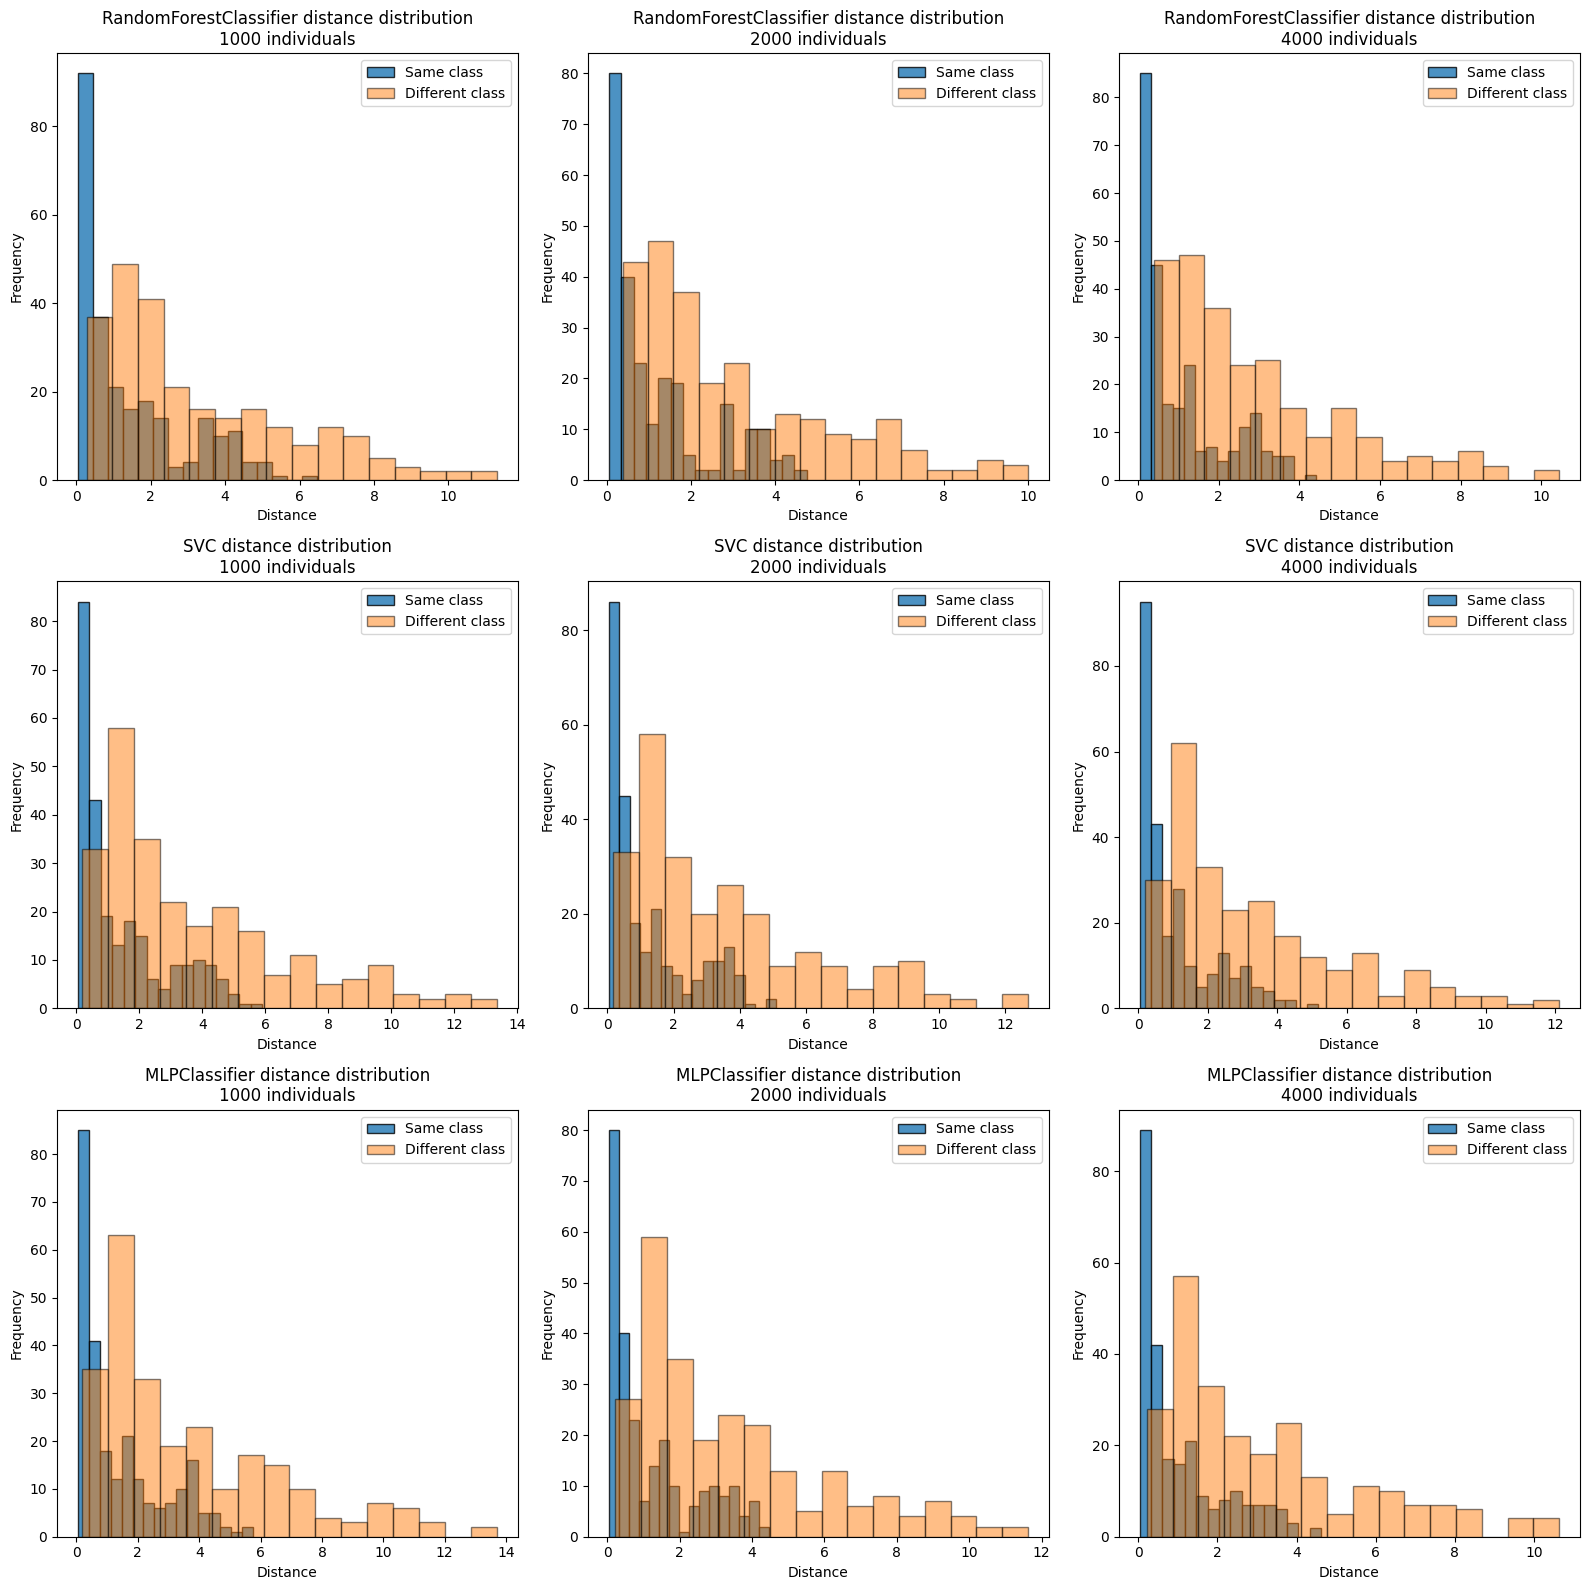

In [3]:
import matplotlib.pyplot as plt


models = df["model"].unique()
sizes = df["population_size"].unique()

fig, axes = plt.subplots(len(models), len(sizes), figsize=(16, 16))

for i, model in enumerate(models):
    for j, size in enumerate(sizes):
        same = (
            (df["model"] == model)
            & (df["class"] == df["target"])
            & (df["population_size"] == size)
        )
        diff = (
            (df["model"] == model)
            & (df["class"] != df["target"])
            & (df["population_size"] == size)
        )
        axes[i][j].set_title(f"{model} distance distribution\n{size} individuals")
        axes[i][j].set_xlabel("Distance")
        axes[i][j].set_ylabel("Frequency")

        axes[i][j].hist(
            df[same]["mean_distance"],
            bins=16,
            edgecolor="black",
            alpha=0.8,
            label="Same class",
        )
        axes[i][j].hist(
            df[diff]["mean_distance"],
            bins=16,
            edgecolor="black",
            alpha=0.5,
            label="Different class",
        )
        axes[i][j].legend()

plt.tight_layout()
plt.show()

Dato che al variare del numero di individui della popolazione, non sembrano
esserci grandi differenze nella distribuzione dei valori di fitness medi
possiamo aggregare.


In [8]:
df.groupby(["samples", "features", "classes", "clusters", "model"]).mean().reset_index()

,samples,features,classes,clusters,model,seed,population_size,point,class,target,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,2,2,1,MLPClassifier,2.0,2333.333333,4.5,0.540000,0.5,0.661548,0.575547,0.050138,0.484575,1.0
1,10,2,2,1,RandomForestClassifier,2.0,2333.333333,4.5,0.540000,0.5,0.637710,0.544074,0.058971,0.426051,1.0
2,10,2,2,1,SVC,2.0,2333.333333,4.5,0.540000,0.5,0.656219,0.567164,0.051859,0.473104,1.0
3,10,4,2,1,MLPClassifier,2.0,2333.333333,4.5,0.480000,0.5,1.234861,1.011859,0.133472,0.751700,1.0
4,10,4,2,1,RandomForestClassifier,2.0,2333.333333,4.5,0.500000,0.5,1.216396,0.936213,0.173159,0.595968,1.0
5,10,4,2,1,SVC,2.0,2333.333333,4.5,0.480000,0.5,1.241871,1.019210,0.133480,0.760670,1.0
6,10,8,2,1,MLPClassifier,2.0,2333.333333,4.5,0.573333,0.5,1.945238,1.472567,0.274654,0.949454,1.0
7,10,8,2,1,RandomForestClassifier,2.0,2333.333333,4.5,0.553333,0.5,1.956086,1.391706,0.331413,0.752778,1.0
8,10,8,2,1,SVC,2.0,2333.333333,4.5,0.580000,0.5,1.992422,1.531927,0.266119,1.023435,1.0
9,10,16,2,1,MLPClassifier,2.0,2333.333333,4.5,0.440000,0.5,4.129822,2.967757,0.668333,1.686082,1.0


## Parallelismo e qualità delle soluzioni

Prima di concludere vorrei evidenziare alcune possibili criticità quando si
lavora con la versione parallela di PPGA, prendendo sempre come riferimento il
solito problema. A differenza di DEAP, che parallelizza solo la fase di
valutazione, PPGA parallelizza anche le fasi di crossover, mutazione.

Durante la fase di test sono infatti emerse alcune criticità riguardanti tali
operatori, che in contesto di calcolo parallelo potrebbero portare a
comportamenti inattesi. Le considerazioni di seguito non riguardano le
performance in termini di runtime ma in termini di qualità delle soluzioni.

### Crossover

Dato che la genereazione della popolazione iniziale avviene per copia, la
diversità genetica iniziale è pari a zero. Per un algoritmo genetico, questo
è in generale un problema dato che sfrutta meccanismi come il crossover per
ricombinare i cromosomi tra individui diversi.

Nel nostro caso partiamo però da una situazione in cui tutti gli individui sono
cloni e utilizziamo metodi di crossover come quello a singolo o doppio punto di
crossover. Questi metodi non producono nuovi valori per le feature ma si
limitano ad esplorare i valori già esistenti.

Ne segue che l'applicazione del crossover tra due cloni risulterà nella
generazione di altri due cloni identici tra di loro e ai loro genitori.

### Mutazione

Per le prime iterazioni ci si affida quindi all'operatore di mutazione come
unico meccanismo per introdurre diversità genetica. Il problema è che la
mutazione ha generalmente una probabilità bassa di essere applicata (in genere
20/30%). Se aggiungiamo poi che ogni feature ha una probabilità indipendente di
essere modificata, la probabilità che un individuo scelto per la mutazione,
venga effettivamente modificato, cala ulteriormente.

Quando partizioniamo la popolazione tra molti worker si potrebbe andare
incontro ad un problema nel caso in cui il rapporto

$$\frac{N}{W}$$

dove $N$ è il numero di individui e $W$ è il numero di worker, è troppo basso.
Si rischia che i worker mutino pochi individui o nessuno, lasciando la
diversità genetica bassa per diverse iterazioni.

Per evitare che ciò accada c'è bisogno che la probabilità indipendente di
modificare ogni feature faccia sì che mediamente, almeno una feature venga
modificata. Per esempio ponendola a $1 / L$ dove $L$ è la lunghezza del
cromosoma.

In secondo luogo è necessario che il numero di individui inviato ad ogni worker
sia abbastanza grande da "garantire" un certo numero di individui mutati.

### Seme di casualità

Dato che le fasi di crossover e mutazione fanno leva sulla generazione di
numeri casuali, è necessario avere fare alcune considerazioni. Il **seme** di
casualità deve essere inizializzato per ogni worker in modo da essere sicuri
che sia diverso. Se non inizializzato esplicitamente verrà usata la funzione
`time.time()`, la quale ha una risoluzione dell'ordine dei secondi.

Ne seguirebbe che ogni worker è inizializzato quasi sicuramente con lo stesso
seed e quindi muta gli stessi individui allo stesso modo degli altri worker.
Andiamo quindi a creare $W$ sottopopolazioni tutte identiche tra di loro.
